# 3-body problem
In this notebook, we consider a classical 300-years old mathematical challenge. Isaac Newton has turned his attention to it after stating the gravity law for 2-body case:

$$ \vec{F} = G \frac{M_1 M_2}{R^3}\vec{r} $$

In 2-body case we have 3 degrees of freedom (independent variables) for each body, adding up to 6 in total, and 10 invariants of motion (energy, 3 momentum invariants, 3 angular momentum invariants, and 3 Lagrange-Rung-Lenz vectors), of which only 7 are in involution, so we can easily deduce the closed-form solution as the law written above. Things get less determined as we add the 3rd body. The number of degrees of freedom increases to 9; hence no closed-form solution can be derived. However, we can write down laws of motion in the form of ODE, get the evolution of $x(t)$, and compute the future state of the system. Intuitively 3 bodies might give a much richer repertoire of behavior, i.e., as 2 bodies get too close, they most likely collide without the 3rd one. In contrast, the 3rd may prevent the collision and produce quite fascinating dance patterns. 

For simplicity's sake, we'll consider the 2D case of 3 body system - such a system has enough degrees of freedom to remain "unsolvable" in terms of closed-form, but can be analyzed and solved using numerical calculations. Interestingly enough, this system of equations for different initial conditions can produce a variety of different kinds of motion: periodic, quasi-periodic, and chaotic. The former kind happens as the system gets to precisely the same initial conditions after a specific time interval referred to as _period_. The chaotic sort of motion is characterized by high dependency on the initial conditions, i.e., the small change in the conditions may lead to drastically different states in the future. Such unpredictability may happen due to close contact of two bodies when forces might get too large, and small differences in motion may lead to different trajectories. The study of such chaotic behaviors gave rise to a whole new branch of science called [_chaos theory_](https://en.wikipedia.org/wiki/Chaos_theory). 

Let's take a look at the following cases:
- Sun-Earth-Jupiter (periodic)
- Periodic orbits (periodic)
- Kepler-16 binary star system (periodic)
- Chaotic system (chaotic)

Your goal would be to understand what system stability is and how do chaotic regimes differ from stable ones. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from scipy.integrate import odeint

%matplotlib inline

As with the previous notebook, here we rely on the following motion equations:

$$ \vec{F_1}=\frac{G m_1 m_2}{r_{12}^{3}} \vec{r_{12}} + \frac{G m_1 m_3}{r_{13}^{3}} \vec{r_{13}}$$

where $\vec{r_{ij}}$ is a vector connecting i-th and j-th bodies. So in the differential form we get:

\begin{aligned}
\frac{d^{2} x_1}{d t^{2}}= \frac{G m_2 \left(x_2-x_1\right)}{r_{12}^{3}}  + \frac{G m_3 \left(x_3-x_1\right)}{r_{13}^{3}}  \\
\frac{d^{2} y_1}{d t^{2}}= \frac{G m_2 \left(y_2-y_1\right)}{r_{12}^{3}}  + \frac{G m_3 \left(y_3-y_1\right)}{r_{13}^{3}}  \\
\end{aligned}

and the other four equations can be obtained by cyclic permutations 1 → 2 → 3 → 1

As in the previous notebook we create a first-order equation system that can be written in Python in the following way:

In [2]:
def derivative(X, t, m1, m2, m3, G):
    dXdt = np.zeros_like(X)
    dXdt[:6] = X[6:]

    r12, r13, r23 = X[2:4] - X[0:2], X[4:6] - X[0:2], X[4:6] - X[2:4]
    frac12 = ((r12**2).sum())**-1.5
    frac13 = ((r13**2).sum())**-1.5
    frac23 = ((r23**2).sum())**-1.5

    dXdt[6:8]   =  G*(r12*frac12*m2 + r13*frac13*m3)
    dXdt[8:10]  =  G*(r23*frac23*m3 - r12*frac12*m1)
    dXdt[10:12] = -G*(r13*frac13*m1 + r23*frac23*m2)

    return dXdt

In [3]:
# Let's define different G constants that we'll use for space and mathematical system simulation.
G_phys = 4 * np.pi**2  # For astronomical units
G_math = 1
# Some aux ODE solver params needed for tough (close encounter) cases 
tol  = 1e-9 # determine the error threshold controlled by the solver
hmax = 1e-4 # max size of the step taken by solver

### Sun - Earth - Jupiter system

In [4]:
# Let's define initial state: masses, coordinates and velocities in astronomical units
mSun_si = 1.9885e30
mEarth_si = 5.972e24
mJup_si = 1.898e27

m1, m2, m3 = mSun_si/mSun_si, mEarth_si/mSun_si, mJup_si/mSun_si

x0 = [0.0, 0.0] + [1.0, 0.0] + [-5.2, 0.0]
v0 = [0.0, 0.0] + [0.0, 6.283] + [0.0, -2.89] 
X0 = np.array(x0 + v0)

# Timespan for the simulation
t = np.linspace(0, 60, 30001)

In [5]:
%%time
# Solving the ODE system given the conditions
solution_sej = odeint(derivative, X0, t, args=(m1, m2, m3, G_phys))

CPU times: user 413 ms, sys: 6.28 ms, total: 420 ms
Wall time: 417 ms


In [6]:
# Let's define some plotting routines
def get_color(i):
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']
    return colors[i]

def plot_solution(solution, t, xlim=(-6, 6), ylim=(-4, 4), labels=['Body-1', 'Body-2', 'Body-3']):
    xy3, xy4, xy5 = solution.T[:6].reshape(3,2,-1)
    paths         = [xy3, xy4, xy5]
    plt.figure(figsize=(8,10), dpi=100)
    plt.subplot(2, 1, 1)
    for i, (x, y) in enumerate(paths):
        plt.plot(x, y, alpha=0.4)
    for i, (x, y) in enumerate(paths):
        plt.plot(x[:1], y[:1], 'o', color=get_color(i), label=labels[i])
    plt.xlim(*xlim)
    plt.ylim(*ylim)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title("3-body XY phase space")
    plt.legend()
    
    plt.subplot(4,1,3)
    for x, y in paths:
        plt.plot(t, x)
    plt.ylim(xlim)
    plt.ylabel('x')
    plt.subplot(4,1,4)
    for x, y in paths:
        plt.plot(t, y)
    plt.ylim(ylim)
    plt.ylabel('y')
    plt.xlabel('time')

    plt.show()

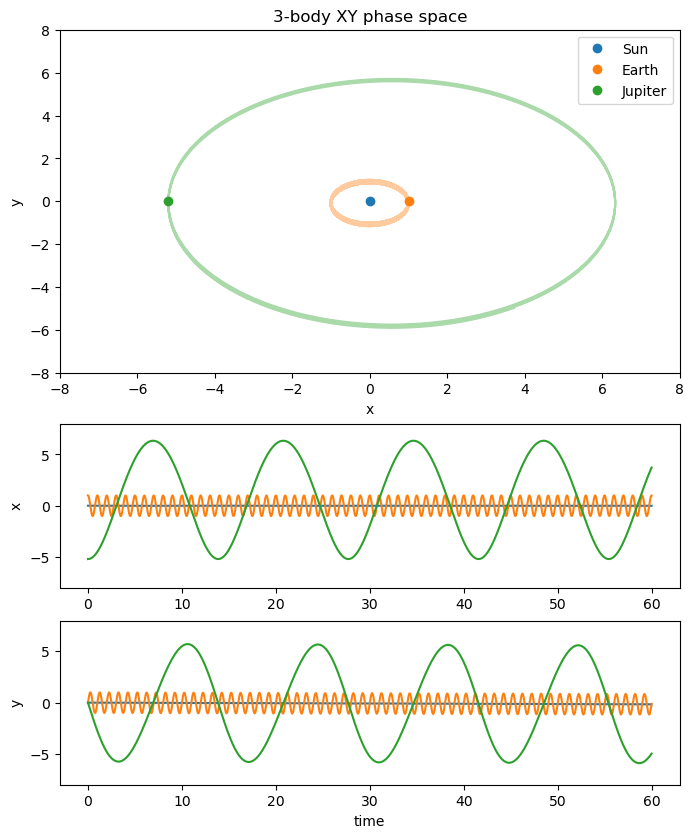

In [7]:
plot_solution(solution_sej, t, xlim=(-8, 8), ylim=(-8, 8), labels=['Sun', 'Earth', 'Jupiter'])

This configuration is pretty stable, i.e., if you modify initial conditions a bit (by 0.1%, or displacing the Earth by several diameters), after 60 years of simulated time, you still get the same planets circling the Sun.

In [8]:
# TODO: update X0 by small percentage and check the difference
X0_mod = X0 + X0 * 0.001

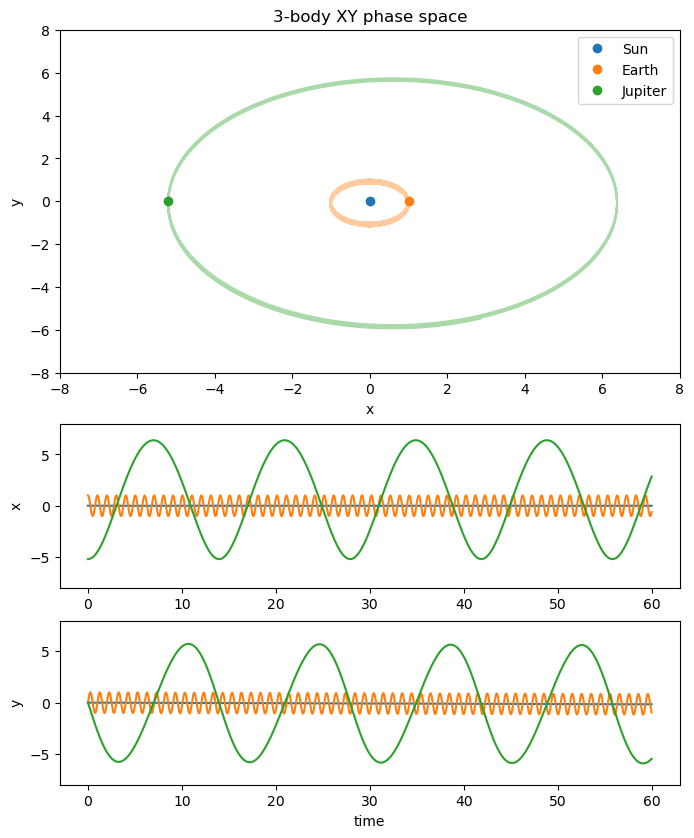

In [9]:
solution_sej2 = odeint(derivative, X0_mod, t, args=(m1, m2, m3, G_phys))
plot_solution(solution_sej2, t, xlim=(-8, 8), ylim=(-8, 8), labels=['Sun', 'Earth', 'Jupiter'])

## Periodic solutions

### Euler solution
There are several families of periodic solutions. For example, Euler has discovered a configuration of 3 bodies that are always colinear and are rotating around the common mass center:
![euler](https://github.com/HSE-LAMBDA/ML-IDS/raw/main/course_1/1_topic/3body_euler.png)

On the left is a trajectory of equal masses, while for the right, the masses are different. Euler's solution was not stable. 



### Lagrange solution

Lagrange has suggested a configuration, in which 3 bodies occupy vertices of an equilateral triangle. Unlike Euler solution it was a bit more stable.

![lagrange](https://github.com/HSE-LAMBDA/ML-IDS/raw/main/course_1/1_topic/3body_lagrange.png)

### Figure-8 solution
Long after Euler and Lagrange’s solutions, another particular solution was found: the figure-eight solution. First discovered numerically by Cristopher Moore in 1993, its existence was rigorously proved in 2001 by Alain Chenciner and Richard Montgomery [cite](https://arxiv.org/pdf/math/0011268.pdf). Unlike the other particular solutions, it only occurs in the case of three equal masses, but remarkably is stable. In the figure eight solution, all three bodies trace the same figure-eight shaped orbit, with a double point at the center also being the center of mass.




In [10]:
# 8-cycle
m1, m2, m3 = 1.0, 1.0, 1.0


x0 = [-0.97000436, 0.24308753] + [0.97000436, -0.24308753] + [0.0, 0.0]
v0 = [ 0.93240737/2, 0.86473146/2] + [ 0.93240737/2, 0.86473146/2] + [-0.93240737, -0.86473146] 
X0 = np.array(x0 + v0)

t = np.linspace(0, 10,  6001)

In [11]:
%%time
solution_8 = odeint(derivative, X0, t, args=(m1, m2, m3, G_math))

CPU times: user 38.1 ms, sys: 1.14 ms, total: 39.3 ms
Wall time: 46.7 ms


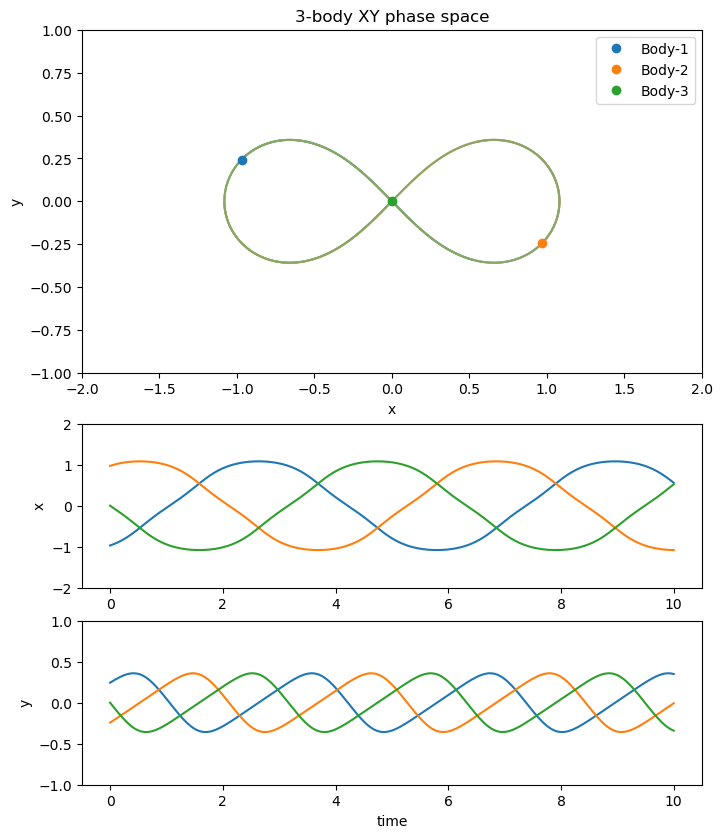

In [12]:
plot_solution(solution_8, t, xlim=(-2, 2), ylim=(-1, 1))

## Further into the space
Another natural science example of a periodic orbit is represented by Kepler-16 system discovered in 2011 by [Kepler telecope](https://en.wikipedia.org/wiki/Kepler_space_telescope)). The system consists of a binary star (stars A and B) and a planet (b) rotating around the stars:
http://exoplanet.eu/catalog/kepler-16_%28ab%29_b/

Kepler-16b has been dubbed as Tatooine (from Star Wars universe), due to the double sunset
<img src="https://i.imgur.com/HYA25rgl.jpg"> 
Image taken from https://www.cosmosup.com/tatooine-like-planets-with-twin-sunsets-may-be-common-in-universe/

In [13]:
# def speed_si2au(v): return 6.283/29.8*v
# def speed_au2si(v): return 29.8/6.283*v

m1, m2, m3 = 0.654, 0.1959, 0.3333 * mJup_si/mSun_si

x0 = [(m2 * 0.224)/(m1 + m2), 0.0] +   \
     [-(m1 * 0.224)/(m1 + m2), 0.0] + \
     [0.7048, 0.0]
v0 = [0.0, 2*np.pi*x0[0]/(41/365.25)] + \
     [0.0, 2*np.pi*x0[2]/(41/365.25)] + \
     [0.0, 2*np.pi*x0[4]/(228/365.25)]
X0 = np.array(x0 + v0)

t = np.linspace(0, 10,  10001)

In [14]:
%%time 
solution_kepler16 = odeint(derivative, X0, t, rtol=tol, atol=tol, args=(m1, m2, m3, G_phys))

CPU times: user 521 ms, sys: 6.78 ms, total: 528 ms
Wall time: 525 ms


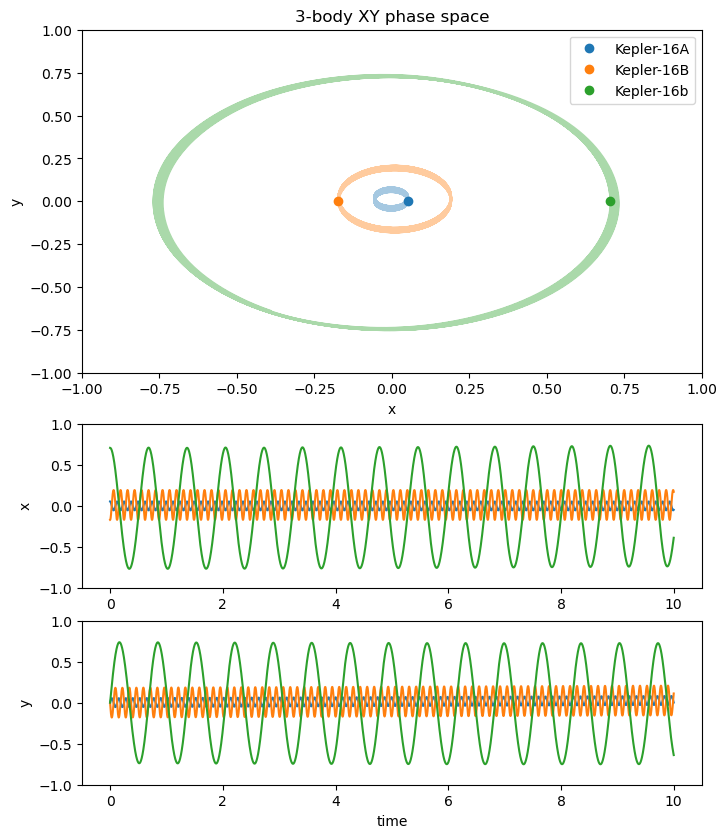

In [15]:
plot_solution(solution_kepler16, t, xlim=(-1,1), ylim=(-1,1), labels=['Kepler-16A', 'Kepler-16B', 'Kepler-16b'])

Many more periodic solutions has been discovered since then [[1]](http://www.sciencemag.org/news/2013/03/physicists-discover-whopping-13-new-solutions-three-body-problem)[[2]](http://www.scl.rs/theses/msc_ahudomal.pdf)[[3]](https://doi.org/10.1093%2Fpasj%2Fpsy057). Studies of those configurations are interesting not just from pure mathematical point of view. Since the discovery of gravitational waves, we can observe gravitational patterns emitted by distant space objects. However, the collapsing black-stars are rather rare events. On the contrary, periodic configurations of binary stars and planets are much more frequent, and each configuration is associated with specific gravitational wave pattern, so the study of the periodic configurations may give a hint about distant space star formation. 

In [16]:
# One more plotting routine
def plot_joint(solution, body_number, var='v', kind='scatter'):
    """
    plots a joint distributions of coordinates
    solution - evolution of a system
    body_number - 0..2 
    var - either 'x' or 'v'
    kind - { "scatter" | "reg" | "resid" | "kde" | "hex" }
    """
    xy1, xy2, xy3 = solution.T[:6].reshape(3,2,-1)
    v1, v2, v3    = solution.T[6:12].reshape(3,2,-1)
    paths         = [xy1, xy2, xy3]
    speed         = [v1, v2, v3]
    plt.figure(figsize=(4,3), dpi=100)
    title = "Joint distribution of {} variable for body {}".format(var, body_number+1)
    if var == 'v':
        data = speed[body_number]
    else:
        data = paths[body_number]        
    plot = sn.jointplot(speed[body_number][0], speed[body_number][1], color=get_color(body_number), kind=kind)
    plot.ax_marg_x.set_title(title)
    return None


Take a look at one more data representation. In the center, you see the plot of the so-called _joint distribution_ of two variables ($x_3, y_3$). You can change the way it plots by changing `kind` argument of the function:
- if `kind` equals to `scatter`, it plots every possible point as a dot, pretty much like at all figures above
- if it equals to `hex`, it aggregates all scattered plots by hexagonal tiles of the corresponding intensity
- if it equals to `kde`, it approximates the point density by a smooth curve

On the top and on the right from the central figure, you can see so-called _marginal distributions_ that intuitively look like projections of the joint distribution to the corresponding axis.

/Users/anaderi/miniconda3/envs/py3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<Figure size 400x300 with 0 Axes>

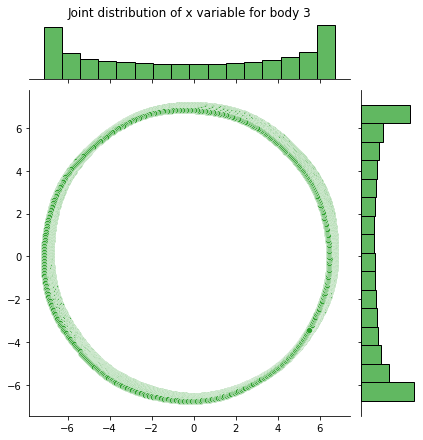

In [17]:
plot_joint(solution_kepler16, 2, var='x', kind='scatter');

In [18]:
# TODO redraw the joint distribution with `kind='kde'` and `kind='hex'` arguments and compare with the figure above

In [19]:
def plot_histograms(solution):
    xy1, xy2, xy3 = solution.T[:6].reshape(3,2,-1)
    v1, v2, v3    = solution.T[6:12].reshape(3,2,-1)
    paths         = [xy1, xy2, xy3]
    speed         = [v1, v2, v3]
    plt.figure(figsize=(10,6), dpi=100)
    bins=15
    
    for i, (x, y) in enumerate(paths):
        c = get_color(i)
        plt.subplot(3, 2, 2*i + 1, title="Body-{}".format(i + 1))
        plt.hist(x, bins=bins, label='x', alpha=0.3, color=c)
        plt.hist(y, bins=bins, label='y', alpha=0.9, histtype='step', color=c)
        plt.legend()
     
    for i, (vx, vy) in enumerate(speed):
        c = get_color(i)
        plt.subplot(3, 2, 2*i + 2)
        plt.hist(vx, bins=bins, label='vx', alpha=0.3, color=c)
        plt.hist(vy, bins=bins, label='vy', alpha=0.9, histtype='step', color=c)
        plt.legend()
        
    plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9, hspace=0.5)
    plt.show()

Below, you can see all the marginal distributions corresponding to each of the variables of our system. So there are 6 different plots and each plot represent two distributions by histograms, showing density of our data in the corresponding interval.

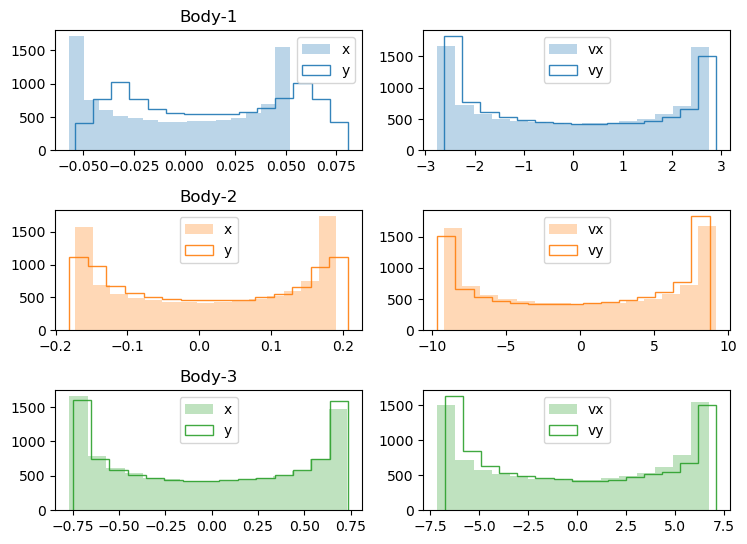

In [20]:
plot_histograms(solution_kepler16)

## Chaotic regime

In [21]:
# from polar to cartesian transform
#def p2c(r, theta):
#    return [r*np.cos(theta), r*np.sin(theta)]

m1, m2, m3 = 1, 1, 1

x0 = [1.0, 0.0] + [-0.4999999999999998, 0.866025] + [-0.5000000000000004, -0.8660254037844384]
v0 = [3.367778697655222e-17, 0.55] + \
    [-0.4763139720814414, -0.2749999999999999] + \
    [0.47631397208144116, -0.27500000000000024]
X0 = np.array(x0 + v0)

t = np.linspace(0, 60,  60001)

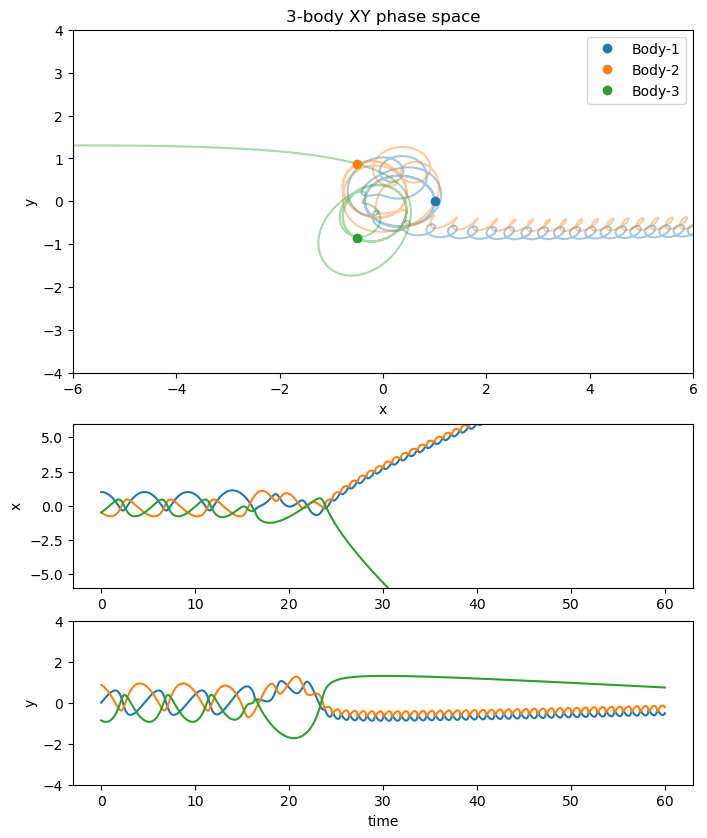

CPU times: user 26.3 s, sys: 162 ms, total: 26.5 s
Wall time: 26.7 s


In [22]:
%%time 
solution_chaos, _ = odeint(derivative, X0, t, args=(m1, m2, m3, G_math), 
                           rtol=tol, atol=tol, hmax=hmax, full_output=True)
plot_solution(solution_chaos, t)

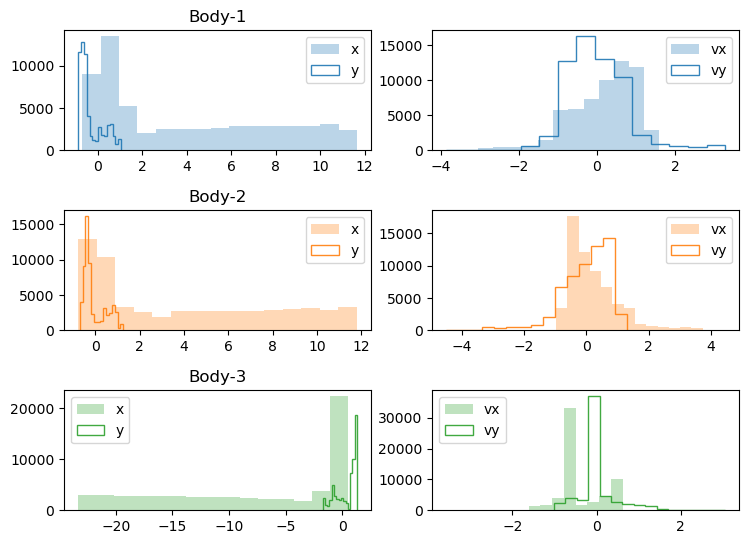

In [23]:
plot_histograms(solution_chaos)

## Task
    Q: What is the biggest change you can make to the initial value of $x_1$ of "Chaotic" configuration so the behaviour of the system will be indistinguishable by the naked eye from the original configuration evolution during the first 20 time ticks?

In [24]:
# TODO: experiment with the perturbation value that would affect the result of the simulation
perturbation = 1e-2
X0_mod = X0
X0_mod[0] = X0[0] * (1 + perturbation)
X0_mod

array([ 1.01000000e+00,  0.00000000e+00, -5.00000000e-01,  8.66025000e-01,
       -5.00000000e-01, -8.66025404e-01,  3.36777870e-17,  5.50000000e-01,
       -4.76313972e-01, -2.75000000e-01,  4.76313972e-01, -2.75000000e-01])

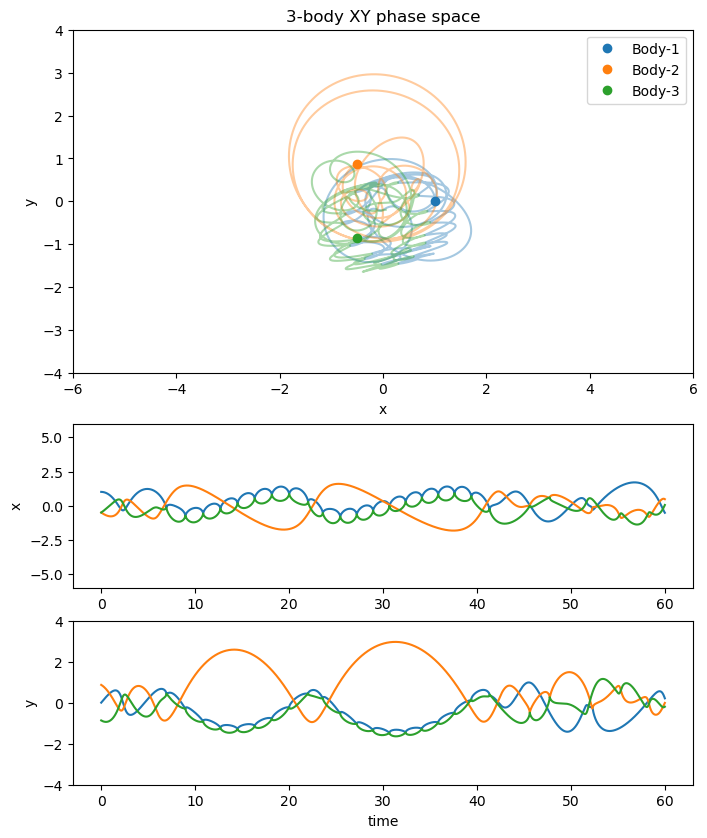

CPU times: user 27.3 s, sys: 193 ms, total: 27.5 s
Wall time: 28 s


In [25]:
%%time 
solution_chaos2, _ = odeint(derivative, X0_mod, t, args=(m1, m2, m3, G_math), rtol=tol, atol=tol, hmax=hmax,  full_output=True)
plot_solution(solution_chaos2, t)

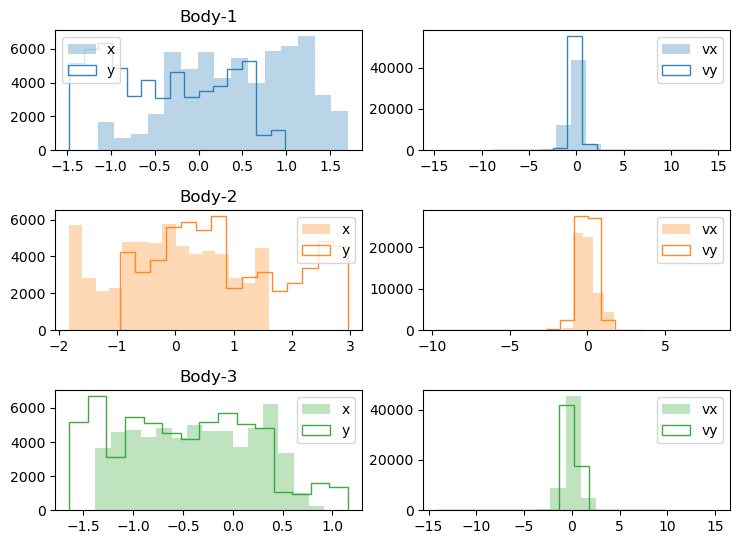

In [26]:
plot_histograms(solution_chaos2)

We hope you've enjoyed this chaotic 3-body detour. It is indeed a marvelous problem, given its apparent simplicity and richness of repertoire. [Wikipedia](https://en.wikipedia.org/wiki/Three-body_problem) is always a good source of inspiration. Also, before concluding, it worths mentioning the [paper](https://arxiv.org/abs/1910.07291) by Breen P. et al. that improved accuracy and speed of ODE solving engine by training a neural net to find a good-enough solution with lightning speed.